<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# _*Qiskit Aqua: Using a linear systems of equations solver (HHL) to perform policy iteration.*_

***
### Contributors
Pablo Antonio Moreno Casares<sup>[1]</sup>, Santiago Varona<sup>[1]</sup>, Alfredo Colosu<sup>[2]</sup>, Ana Martin<sup>[3]</sup>, Pablo Barrio.
### Affiliation
- <sup>[1]</sup>Grupo de Información y Computación Cuánticas, Universidad Complutense de Madrid
- <sup>[2]</sup>Facultad de Matemáticas, Universidad Complutense de Madrid
- <sup>[3]</sup>Quantum Technologies for Information Science group, Universidad del País Vasco

Policy iteration algorithm [1] is a basic Reinforcement Learning algorithm very similar to the more common value iteration. Its procedure can be seen in the following image
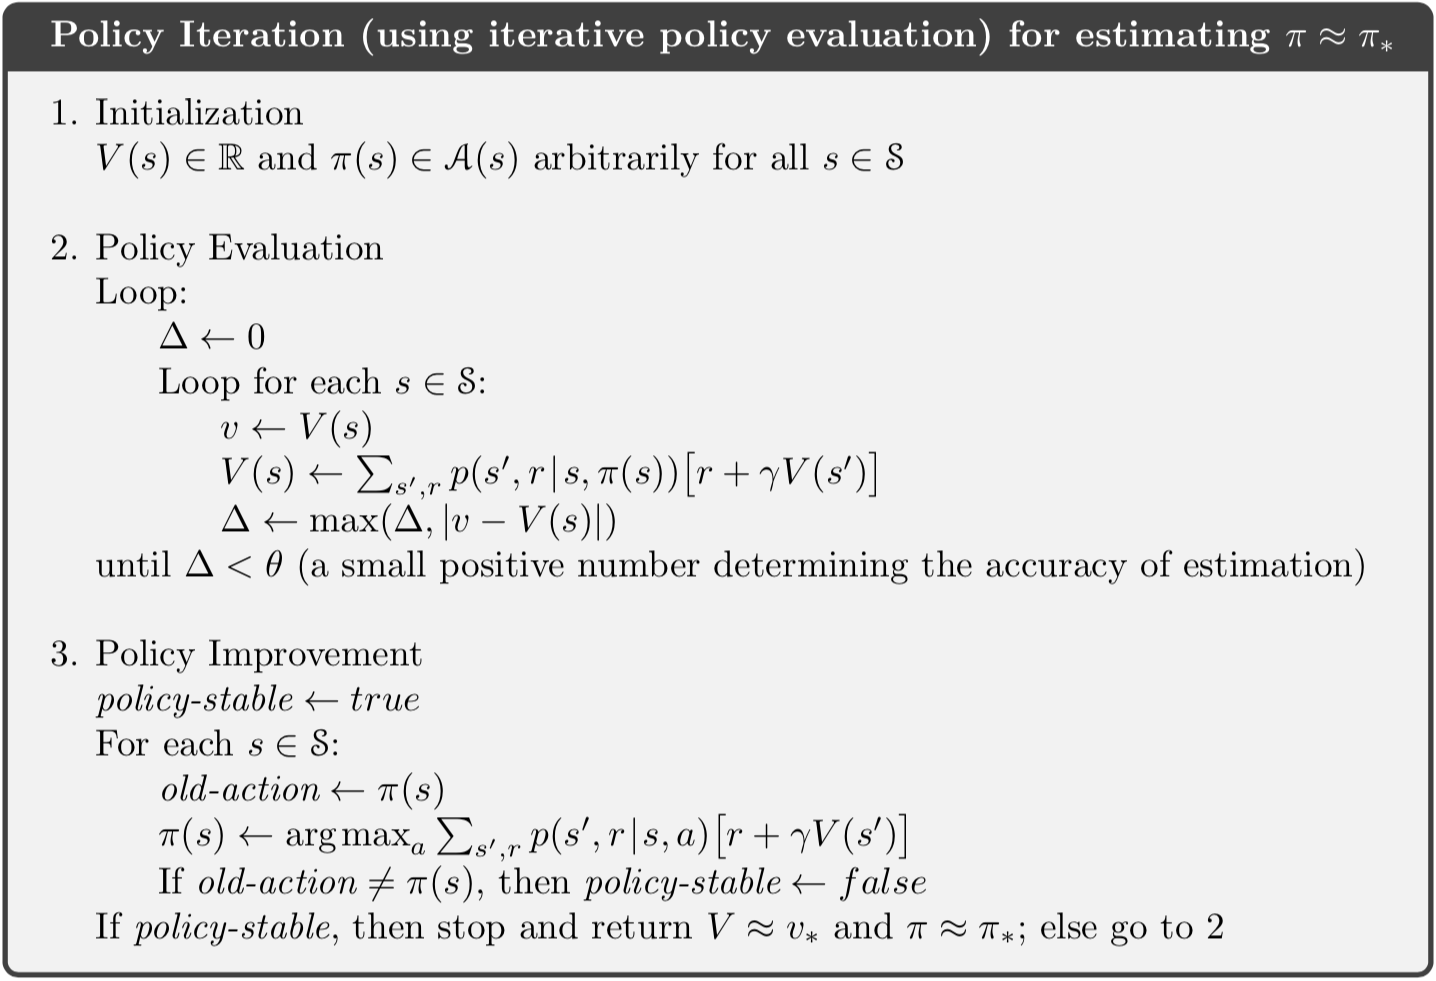

On the other hand, the inner loop in the step named "Policy evaluation" can be reframed into solving a linear system of equations. 
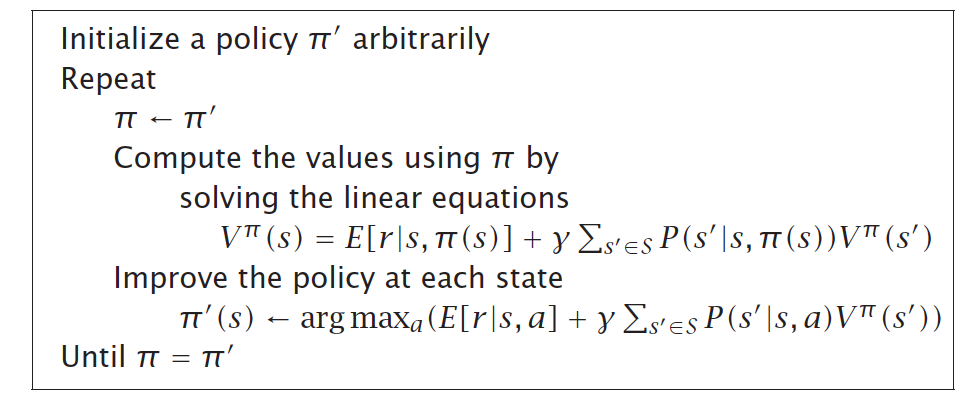
(Credit: Alpaydin Introduction to Machine Learning, 3rd edition.)

The algorithm to solve the linear system of equations is HHL [2] However, since the entries of $V^\pi$ can not be efficiently read out because we would need to know all coefficients describing the quantum state. Therefore we instead carry out an inner product with $P(s'|s,a)$ using the standard Swap Test which is efficient in the number of states.

However, we must point out that since in the step "Policy improvement" we have to iterate over all states, this means that the quantum advantage is gone (the algorithm is polynomial in the number of steps), so this particular algorithm does not get a quantum advantage as we had hoped, but rather serves as an example of fun things one can do with Qiskit.

References:
1. Sutton, Richard S., and Andrew G. Barto. Introduction to reinforcement learning. Vol. 2. No. 4. Cambridge: MIT press, 1998.
2. A. W. Harrow, A. Hassidim, and S. Lloyd, Phys. Rev. Lett. 103, 150502 (2009), e-print arXiv 0811.3171

Previous version of this code is: https://github.com/PabloAMC/QRL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from gym.envs.toy_text import discrete
import time
import timeit
import random
import seaborn as sns
from matplotlib.patches import Arrow
import multiprocessing

import qiskit
from qiskit.aqua.input import LinearSystemInput
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms.classical import ExactLSsolver
from qiskit import BasicAer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.single_sample import HHL
from qiskit import IBMQ

We will run policy iteration in a small sized gridworld of type frozenlake.

In [2]:
# Parameters
tam = 2 #Size of the gridworld

#Assign parameters to the action (movement) the agent can take
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

#Special cells
HOLES = {2}
GOAL = {3}

SLP = 0 #Indicates if the agent is sleepy. Set to 0 by default

Now we define the gridworld, with the structures needed to perform policy iteration

In [ ]:
# Environment
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[2, 2]):
        
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape) # number of states
        nA = 4              # number of actions
        slp = 100 - SLP     # 1 - percentage of sleepiness

        self.MAX_Y = shape[0]    # shape of the gridworld, x direction
        self.MAX_X = shape[1]    # shape of the gridworld, y direction

        P = {}              # dictionary of [states] [actions] = ([1.0, next_state, reward, is_done])
        self.grid = np.zeros(shape) - 1.0
        it = np.nditer(self.grid, flags=['multi_index']) # iteration over array 'grid'
        
        '''
        Numeration of the matrix 4x4 is as follows:
        0 1 2 3
        4 5 6 7
        8 9 10 11
        12 23 14 15
        '''

        while not it.finished:
            s = it.iterindex                    # states
            y, x = it.multi_index

            if s == (nS - 1):
                self.grid[y][x] = 0.0

            P[s] = {a : [] for a in range(nA)}  # dictionary with info of state, action and reward

            is_done = lambda s: s in GOAL #can be modified to include more goals
            is_dead = lambda s: s in HOLES #can be modified to include more holes
            reward = 1.0 if is_done(s) else -1.0 if is_dead(s) else 0.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            #else:           #One may want to include some kind of list of goal states to substitute the next four lines.
            ns_up = s if y == 0 else s - self.MAX_X # move one full row to the left
            ns_right = s if x == (self.MAX_X - 1) else s + 1
            ns_down = s if y == (self.MAX_Y - 1) else s + self.MAX_X # move one full row to the right
            ns_left = s if x == 0 else s - 1
            
            def rand_choice(orig):
                r = random.randint(0,3)
                if r == 0:
                    return ns_up
                elif r == 1:
                    return ns_right
                elif r == 2:
                    return ns_down
                elif r == 3:
                    return ns_left
                else:
                    return orig
            
            P[s][UP] = [(1.0, ns_up if random.randint(0,100) < slp else rand_choice(ns_up), reward, False)]
            P[s][RIGHT] = [(1.0, ns_right if random.randint(0,100) < slp else rand_choice(ns_right), reward, False)]
            P[s][DOWN] = [(1.0, ns_down if random.randint(0,100) < slp else rand_choice(ns_down), reward, False)]
            P[s][LEFT] = [(1.0, ns_left if random.randint(0,100) < slp else rand_choice(ns_left), reward, False)]


            it.iternext()

        # Initial state distribution is uniform
        isd = np.zeros(nS)
        isd[0] = 1 # The agent starts in cell 0
        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

Next we define the quantum circuit to be run

In [ ]:
def build_circuit(matrix, vector_u, vector_p):
    n_io = int(np.log2(np.size(vector_u)))
    # vector_p /= np.linalg.norm(vector_p)
    # Parameters for HHL algorithm
    num_ancillae = 3
    num_time_slices = 50
    params = dict()
    params['problem'] = {
        'name': 'linear_system'
    }
    params['backend'] = {
        'provider': 'qiskit.BasicAer',
        'name': 'statevector_simulator'
    }
    params['algorithm'] = {
        'truncate_powerdim': False,
        'truncate_hermitian': False
    }
    params['reciprocal'] = {
        'name': 'Lookup',
        'negative_evals': True
    }
    params['eigs'] = {
        'expansion_mode': 'suzuki',
        'expansion_order': 2,
        'name': 'EigsQPE',
        'negative_evals': True,
        'num_ancillae': num_ancillae,
        'num_time_slices': num_time_slices
    }
    params['initial_state'] = {
        'name': 'CUSTOM'
    }
    params['iqft'] = {
        'name': 'STANDARD'
    }
    params['qft'] = {
        'name': 'STANDARD'
    }
    algo_input = LinearSystemInput(matrix=matrix, vector=vector_u)
    hhl = HHL.init_params(params, algo_input)
    # Quantum circuit for HHL
    qc = hhl.construct_circuit()
    # HHL solution output register and success bit register
    io = hhl._io_register
    anc1 = hhl._ancilla_register
    # Quantum registers for Swap test. 
    psas = QuantumRegister(n_io, 'psas') #Psas stands for the vector P(s'|as)
    anc2 = QuantumRegister(1, 'anc2') #ancilla needed for the swap test
    c1 = ClassicalRegister(1, 'c1')
    c2 = ClassicalRegister(1, 'c2')
    # Add registers to quantum circuit
    qc.add_register(psas, anc2, c1, c2)
    # Initialize vector_p on psas register
    qc.initialize(vector_p, psas)
    # exit(0)
    # Swap test: control swap for dot product
    qc.h(anc2)
    for i in range(n_io):
        qc.cswap(anc2, psas[i], io[i])
    qc.h(anc2)
    # Projection and meassurement
    qc.barrier(anc1)
    qc.barrier(anc2)
    qc.measure(anc1, c1)
    qc.measure(anc2, c2)
    return qc

And when we have defined the quantum circuit we specify the number of runs and the classical operations needed to extract information from it

In [ ]:
def quantum_solver(matrix, vector_u, vector_p):
    assert np.abs(np.linalg.norm(vector_u))-1<1e-10 # assert vector_u is normalized
    assert np.abs(np.linalg.norm(vector_p))-1<1e-10 # assert vector_p is normalized
    kappa = np.linalg.cond(matrix) #Needed to normalize the solution, although we will not need it.
    shots = 8192
    qc = build_circuit(matrix, vector_u, vector_p)

    backend_qasm = BasicAer.get_backend('qasm_simulator')
    job_qasm = execute(qc, backend_qasm, shots=shots)
    result_qasm = job_qasm.result()
    counts = result_qasm.get_counts(qc)

    # backend_state=BasicAer.get_backend('statevector_simulator')
    # job_state=execute(qc,backend_state)
    # result_state=job_state.result()
    # outputstate=result_state.get_statevector(qc,decimals=3)
    # print(outputstate)
    # import pdb; pdb.set_trace()
    # return
    
    # Classical calculations of the swap test
    error = 0
    success = 0
    for key, value in counts.items():
        k = key.split()
        if int(k[1]) == 0:
            error += value
        elif int(k[0]) == 0:
            success += value
    prob2 = 1 - success/(shots-error) # Probability of failure of anc2
    if prob2 > 0.5: prob2 = .5
    dot_product = np.sqrt(1-2*prob2) #*np.linalg.norm(vector_p) # kappa*np.sqrt(prob1)
    return dot_product, counts

And we also create a classical solver so that we can compare the results

In [ ]:
def classical_solver(matrix, vector_u, vector_p):
    A_inv = np.linalg.inv(np.matrix(matrix))
    # vector_u /= np.linalg.norm(vector_u)
    # vector_p /= np.linalg.norm(vector_p)
    x = A_inv*np.matrix(vector_u).T
    x /= np.linalg.norm(x)
    kappa = np.linalg.cond(matrix)
    dot_product = x.T*np.matrix(vector_p).T
    return dot_product, x, kappa

Additionally, to perform policy iteration we will need a transition matrix and a value function for each state

In [ ]:
# Utilities
def trans_mat(env):
    return (np.array([[np.eye(1, env.nS, env.P[s][a][0][1])[0] for a in range(env.nA)] for s in range(env.nS)]),
            np.array([env.P[s][0][0][2] for s in range(env.nS)]))

def expected_utility(a, s, U, trans_probs):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for s1, p in enumerate(trans_probs[s, a, :])])

Now we create a function capable of performing a single policy iteration

In [ ]:
# Policy Iteration
def parllel(tup): #tup stands for tuple and will be given values later
    '''
    Performs one iteration of policy iteration
    '''
    i = tup[0] # Initial state
    j = tup[1] # Action index
    tam = tup[2] # The gridworld is of size tam x tam.
    R = tup[3] # Normalized reward vector
    M = tup[4] # Matrix of the linear system of equations
    trans_probs = tup[5] # Transition probabilities
    gamma = tup[6] # Time damping factor
    U = tup[7] # Value of each state
    
    #Calculate the (expected) reward of the final state
    if j == 0 and i >= tam:
        r = R[i-tam]
    elif j == 1 and (i+1)%tam != 0:
        r = R[i+1]
    elif j == 2 and i+tam < tam*tam:
        r = R[i+tam]
    elif j == 3 and i%tam != 0:
        r = R[i-1]
    else:
        r = R[i]

    product, _ = quantum_solver(M, -R/np.linalg.norm(R), trans_probs[i,j])
    pa = gamma*product
    par = r + pa
    
    return (i,par,j)

Define the function that performs all the loops of policy iteration given initial data

In [3]:
def policy_iteration(trans_probs, reward, tam, grid, im, ax, fig, gamma=0.9, epsilon=1e-3):
    '''
    Performs policy iteration in a loop.
    
    Variables:
     
     trans_probs: transition probabilities
     reward: reward vector
     tam: the gridworld is of size tam x tam
     im: image to be plotted with the value and policy in each state
     ax: axis along which subplots can be plotted
     fig: figure of the resulting values and actions
     gamma: time damping factor
     epsilon: margin allowed in the convergence of policy iteration 
    '''
    pool = multiprocessing.Pool()
    n_states, n_actions, _ = trans_probs.shape
    PI1 = [0 for s in range(n_states)]
    PIs = []
    R = reward
    deltas = []
    delta = 10000 # Maximum number of iterations
    k = 0
    while delta >= epsilon:
        PI = PI1.copy()
        PIs.append(PI)
        delta = 0
        P = np.zeros((n_states, n_states))
        for i in range(n_states):
            P[i] = trans_probs[i,PI[i]]
        M = (gamma*P)-np.eye(n_states)
        U = np.dot(np.linalg.inv(M),(-R))
        
        # paralellise
        data = []
        for i in range(n_states):
            for j in range(n_actions):
                data.append((i, j, tam, R, M, trans_probs, gamma, U))
        
        aux = list(map(parllel, data))
        print(fin)
        lista = [[] for i in range(n_states)]
        for tup in aux:
            lista[tup[0]].append((tup[1], tup[2]))
        for i in range(n_states):
            mayor = max(lista[i],key=lambda x: x[0])
            PI1[i] = mayor[1]
        
        delta = max(abs(np.subtract(PI1, PI)))
        deltas.append(delta)
        k = k+1
        draw_policies(U, PI1, grid, im, k, ax, fig)
        
    return PI1, deltas, U, PIs

And a bunch of functions to print the result as graphics

In [ ]:
def to_mat(u, shape):
    dst = np.zeros(shape)
    for k in range(len(u)):
        dst[k // shape[1], k % shape[1]] = u[k]
    return dst

def add_arrow(pi, shape):
    a = []
    for k in range(len(pi)):
        if pi[k] == UP:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0, -0.45, head_width=0.05))
        elif pi[k] == RIGHT:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0.45, 0, head_width=0.05))
        elif pi[k] == DOWN:
            a.append(plt.arrow(k % shape[1], k // shape[1], 0, 0.45, head_width=0.05))
        elif pi[k] == LEFT:
            a.append(plt.arrow(k % shape[1], k // shape[1], -0.45, 0, head_width=0.05))
    return a

def start_draw_policies(U, PI, grid, ax, fig):
    plt.clf()
    im = plt.imshow(to_mat(U, grid.shape), cmap="summer")
    add_arrow(PI, grid.shape)
    ax.set_title("Iter " + str(0))
    fig.canvas.draw()
    plt.show()
    #plt.pause(1)
    return im
    
def draw_policies(U, PI, grid, im, ite, ax, fig):
    plt.clf()
    im = plt.imshow(to_mat(U, grid.shape), cmap="summer")
    add_arrow(PI, grid.shape)
    ax.set_title("Iter " + str(ite))
    fig.canvas.draw()
    plt.show()
    #plt.pause(1)
    return im

def text_render(pos, is_done, is_dead, tam):
    string = ""
    for i in range(tam*tam):
        if i%tam == 0:
            print(string)
            print("------------------")
            string = "|"
        if i == pos:
            string = string + "S|"
        elif is_done(i):
            string = string + "G|"
        elif is_dead(i):
            string = string + "H|"
        else:
            string = string + "F|"
    print(string)
    print("------------------")
    
def start_render(pos, is_done, is_dead, tam, ite, ax):
    m = np.zeros((tam,tam))
    for i in range(tam):
        for j in range(tam):
            if is_dead(i*tam+j):
                m[i,j] = -10
            elif i*tam+j == pos:
                m[i,j] = 10
            elif is_done(i*tam+j):
                m[i,j] = 5
            else:
                m[i,j] = 0
    im = ax.imshow(m,cmap="viridis")
    return im
    
def render(pos, is_done, is_dead, tam, ite, im):
    m = np.zeros((tam,tam))
    for i in range(tam):
        for j in range(tam):
            if is_dead(i*tam+j):
                m[i,j] = -10
            elif i*tam+j == pos:
                m[i,j] = 10
            elif is_done(i*tam+j):
                m[i,j] = 5
            else:
                m[i,j] = 0
    im.set_data(m)

Finally, we add the main function that tells how to execute the file

In [ ]:
if __name__ == '__main__':
    grid = GridworldEnv(shape=(tam,tam)) # Creates the gridworld
    trans_probs, reward = trans_mat(grid) # Define transition probabilities and reward
    
    fig, ax = plt.subplots()
    ax.axis('off')
    fig.tight_layout()
    im = start_draw_policies([0 for s in range(tam*tam)], [0 for s in range(tam*tam)], grid, ax, fig)
    
    start_time = timeit.default_timer()
    PI, deltas, U, PIs = policy_iteration(trans_probs, reward, tam, grid, im, ax, fig) # Perform policy iteration
    elapsed = timeit.default_timer() - start_time
    print(U)
    print(PI)
    print(elapsed)

    start_draw_policies(U, PI, grid, ax, fig) # Draw the results

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright